# Swing on Strike

```python
#definitions
dfc["batter_div_with_vibe"] = (
    dfc["batter_divinity"] * dfc["batter_mul"] * (1 + 0.2 * dfc["batter_vibes"])
)
dfc["batter_musc_with_vibe"] = # similar to above
dfc["batter_thwack_with_vibe"] = # similar to above
dfc["invpath_with_vibe"] = ( # note the division and when it happens
    (1 - dfc["batter_patheticism"] / dfc["batter_mul"])
    * (1 + 0.2 * dfc["batter_vibes"])
)
dfc["combined_batting"] = 0.25 * (
    dfc["batter_div_with_vibe"]
    + dfc["batter_musc_with_vibe"]
    + dfc["invpath_with_vibe"]
    + dfc["batter_thwack_with_vibe"]
)  # essentially the average of the four

dfc["hypediff_pitcher_vibes"] = (dfc["pitching_team_hype"] - dfc["batting_team_hype"]) * (1 + 0.2 * df["pitcher_vibes"])
dfc["hypediff_batter_vibes"] = (dfc["batting_team_hype"] - dfc["pitching_team_hype"]) * (1 + 0.2 * df["batter_vibes"])


# the formula
# before season 19
dfc["threshold"] = (
    0.60
    + 0.35 * dfc["combined_batting"]
    - 0.40 * dfc["pitcher_ruth_with_vibe"]
    + 0.20 * (dfc["ballpark_viscosity"])
)

# season 19 and on(?)
dfc["threshold"] = (
    0.50
    + 0.35 * dfc["combined_batting"]
    - 0.20 * dfc["pitcher_ruth_with_vibe"]
    + 0.20 * (dfc["ballpark_viscosity"])
    + 0.07 * dfc["hypediff_batter_vibes"]
    - 0.04 * dfc["hypediff_pitcher_vibes"]
)

```
Works for Season 12 thru Season 15, if you avoid several problematic modifiers: `["O_NO", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "TRAVELING"].` Sutton Dreamy's Night Vision Goggles are also being *weird and inconsistent*, and don't always "work" either. There is one weird attractor-placed-in-secret-base roll (Tad Seeth, season 15) that we catch too, which needs to be sorted out (may have already been sorted out by the time you read this actually). But otherwise, this formula is rock-solid.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from csv_dtypes import column_dtypes

import load

In [2]:
season = 18
df = load.data("swing-on-strike", season=season)

df["ruth_vibes"] = load.player_attribute(df, 'pitcher', 'ruthlessness', vibes=True, mods=True, items=True, broken_items=True)

df["div_vibes"] = load.player_attribute(df, 'batter', 'divinity', vibes=True, mods=True, items=True, broken_items=True)
df["musc_vibes"] = load.player_attribute(df, 'batter', 'musclitude', vibes=True, mods=True, items=True, broken_items=True)
df["thwack_vibes"] = load.player_attribute(df, 'batter', 'thwackability', vibes=True, mods=True, items=True, broken_items=True)
df["path_scaled"] = load.player_attribute(df, 'batter', 'patheticism', vibes=False, mods="negative", items="negative", broken_items=True)

# center=True is the default
df["viscosity"] = load.stadium_attribute(df, 'viscosity', center=False)
print(len(df))

116835


In [3]:
df["invpath_vibes"] = (1 - df["path_scaled"]) * (1 + 0.2 * df["batter_vibes"])

df["combined_batting"] = 0.25 * (
    df["div_vibes"]
    + df["musc_vibes"]
    + df["invpath_vibes"]
    + df["thwack_vibes"]
)

df["hypediff"] = df["batting_team_hype"] - df["pitching_team_hype"]
df["hypediff_bvibes"] =(df["batting_team_hype"] - df["pitching_team_hype"]) * (1 + 0.2 * df["batter_vibes"])
df["hypediff_pvibes"] = (df["pitching_team_hype"] - df["batting_team_hype"]) * (1 + 0.2 * df["pitcher_vibes"])

In [4]:
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "CHUNKY", "SMOOTH"]:
# for exclude_mod in ["0", "O_NO", "LATE_TO_PARTY", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "MINIMALIST", "MAXIMALIST",
                    # "SINKING_SHIP", "TRAVELING", "HIGH_PRESSURE", "OVERPERFORMING", "UNDERPERFORMING",]:
for exclude_mod in ["0", "LATE_TO_PARTY"]:
    # for exclude_mod in ["O_NO", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    
dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]

# dfc = dfc[dfc["hypediff"] == 0]


len(dfc)

75021

In [5]:
X = dfc[
    [
        "roll",
        "passed",
        "combined_batting",
        "ruth_vibes",
        "viscosity",
        "hypediff_bvibes",
        "hypediff_pvibes",
    ]
]
y = X["passed"]
X = X.drop("passed", axis=1)


pin_intercept = None
pin_intercept = 0.5
pins = [
    (-0.20, "ruth_vibes"),
    (0.20, "viscosity"),
    (0.35, "combined_batting"),
    (0.07, "hypediff_bvibes"),
    (-0.04, "hypediff_pvibes"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X.shape)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(f"score: {trainedsvm.score(X2, y)} ({len(X2) - sum(np.diag(confusion_matrix(y, predictionsvm)))} outliers)")

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

(75021, 1)
[[23983    15]
 [   10 51013]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     23998
        True       1.00      1.00      1.00     51023

    accuracy                           1.00     75021
   macro avg       1.00      1.00      1.00     75021
weighted avg       1.00      1.00      1.00     75021

score: 0.999666759973874 (25 outliers)
0.5 , intercept
(-0.2, 'ruth_vibes')
(0.2, 'viscosity')
(0.35, 'combined_batting')
(0.07, 'hypediff_bvibes')
(-0.04, 'hypediff_pvibes')


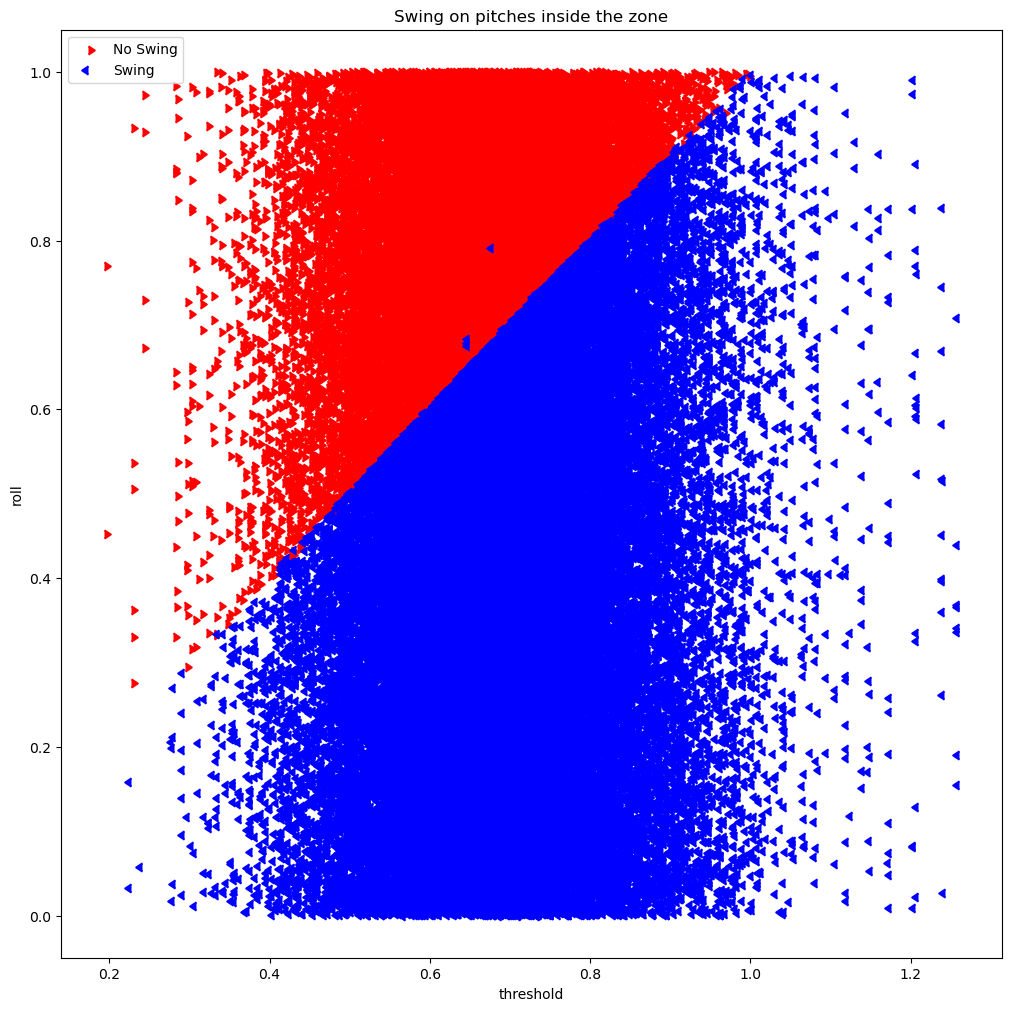

In [6]:
dfc["threshold"] = (
    0.50
    + 0.35 * dfc["combined_batting"]
    - 0.20 * dfc["ruth_vibes"]
    + 0.20 * (dfc["viscosity"])
    + 0.07 * dfc["hypediff_bvibes"]
    - 0.04 * dfc["hypediff_pvibes"]
)

# intercept = intercept_scaled
# dfc['threshold'] = intercept_scaled
# print(intercept_scaled)
# for pair in pins + list(zip(-np.array(coef_list), X.columns)):
#     if "roll" not in pair[1]:
#         print(pair)
#         dfc['threshold'] += pair[0] * dfc[pair[1]]
# dfc["svc"] = dfc["threshold"] - intercept_scaled



x_val = "threshold"
# x_val = "invpath_with_vibe"
fig, ax = plt.subplots(1, figsize=(10, 10), layout="constrained")
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="No Swing",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Swing",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Swing on pitches inside the zone")
# ax.set_xlim(0.484, 0.499)

ax.legend()

25


,passed,offset,roll,threshold,ruth_vibes,combined_batting,viscosity,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,top_of_inning
61019,True,0.113616,0.791760,0.678145,0.921106,0.733405,0.528371,Velasquez Alstott,Helga Burton,FIRE_EATER;UNDERPERFORMING;FIREPROOF;HOMEBODY,,AAA;A;TRAVELING;GOOD_RIDDANCE,SOUNDPROOF;FIREPROOF;LOVE,77,2c93ca34-7063-4a70-a1ea-36a0dadadeea,154,False
58914,True,0.034951,0.683785,0.648834,1.148557,0.779632,0.528371,Velasquez Alstott,Karato Bean,FIRE_EATER;UNDERPERFORMING;FIREPROOF;HOMEBODY,,ELECTRIC;LOVE;TRAVELING;A;GOOD_RIDDANCE,SOUNDPROOF;FIREPROOF;LOVE,76,c97d3807-c3a9-426b-be1f-b9c9930af77f,73,False
59745,True,0.029708,0.678542,0.648834,1.148557,0.779632,0.528371,Velasquez Alstott,Karato Bean,FIRE_EATER;UNDERPERFORMING;FIREPROOF;HOMEBODY,,ELECTRIC;LOVE;TRAVELING;A;GOOD_RIDDANCE,SOUNDPROOF;FIREPROOF;LOVE,76,c97d3807-c3a9-426b-be1f-b9c9930af77f,247,False
59257,True,0.026205,0.675039,0.648834,1.148557,0.779632,0.528371,Velasquez Alstott,Karato Bean,FIRE_EATER;UNDERPERFORMING;FIREPROOF;HOMEBODY,,ELECTRIC;LOVE;TRAVELING;A;GOOD_RIDDANCE,SOUNDPROOF;FIREPROOF;LOVE,76,c97d3807-c3a9-426b-be1f-b9c9930af77f,148,False
25345,True,0.002792,0.737451,0.734659,1.440780,1.310079,0.481398,Margarito Nava,Silvia Rugrat,FIRE_EATER,SIPHON,GROWTH,,44,309d9d03-3c73-4b61-b4be-e7a04b9cc003,67,True
15465,True,0.002253,0.732564,0.730311,0.716925,0.968880,0.431210,Nagomi Nava,Caleb Alvarado,FIRE_EATER;UNDERPERFORMING;HOMEBODY,REPEATING;FRIEND_OF_CROWS,BASE_INSTINCTS,,37,4d507e3f-bec7-4259-a604-84f1fb60ab18,225,True
79342,True,0.001737,0.694812,0.693076,1.391633,1.117820,0.400827,Nagomi Nava,Brock Forbes,FIRE_EATER;UNDERPERFORMING;HOMEBODY,WILD,BASE_INSTINCTS,GROWTH,67,defd4aff-c270-4a77-9072-1033a3c7bd34,18,True
78344,True,0.001452,0.595287,0.593835,1.152316,0.697522,0.400827,Chambers Simmons,Zack Sanders,,,GROWTH,BASE_INSTINCTS,66,8ccff2c9-64cf-4cc3-96d2-fed398bcc038,127,False
78323,True,0.000428,0.489049,0.488621,1.152316,0.396910,0.400827,Hierophantic Foible,Zack Sanders,HIGH_PRESSURE,,GROWTH,BASE_INSTINCTS,66,8ccff2c9-64cf-4cc3-96d2-fed398bcc038,122,False
74721,True,0.000345,0.529530,0.529185,1.032976,0.415072,0.400827,NaN,Alexandria Rosales,ECHO;WANDERER;ALTERNATE;FLICKERING,UNDEFINED,GROWTH,PSYCHIC,63,5aa53182-047e-47ad-804f-866fa971c28b,378,False


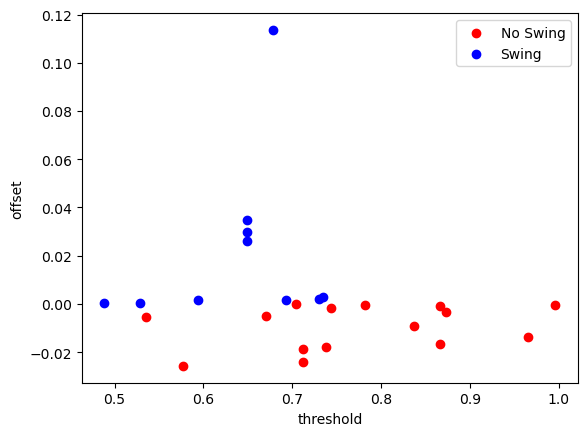

In [7]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Swing",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Swing",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
print(len(table))
table = table[
    [
        "passed",
        "offset",  # "home_score", "away_score", "top_of_inning", "inning",
        "roll",
        "threshold",
        # "pitcher_mul",
        # "batter_mul",
        # "baserunner_count",
        # "batter_vibes", "pitcher_vibes",
        "ruth_vibes",
        # "invpath_vibes",
        "combined_batting",
        "viscosity",
        # "batter_musclitude", "batter_divinity", "batter_thwackability", "batter_patheticism",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "day",
        "game_id",
        "play_count",
        # "weather",
        "top_of_inning",
    ]
].sort_values("offset", ascending=False)
# len(table)
# print(table['offset']/table['threshold'])
table

In [8]:
print(table.groupby("pitching_team_mods").size())
print(table.groupby("batting_team_mods").size())
print(table.groupby("batter_mods").size())
print(table.groupby("pitcher_mods").size())

pitching_team_mods
                                         4
BASE_INSTINCTS                           2
BIRD_SEED                                1
FIREPROOF;PARTY_TIME                     1
GOOD_RIDDANCE;A;TRAVELING;AA             2
GOOD_RIDDANCE;A;TRAVELING;PSYCHIC        1
GROWTH                                   1
HOME_FIELD;SHAME_GIVER;LIFE_OF_PARTY     1
MAINTENANCE_MODE;STALEPOPCORN_PAYOUTS    1
O_NO                                     2
O_NO;A;TRAVELING;GOOD_RIDDANCE           1
PSYCHIC                                  2
SINKING_SHIP                             1
SOUNDPROOF;FIREPROOF;LOVE                4
SUN2_PAYOUTS;SUN_KISSED;ACIDIC           1
dtype: int64
batting_team_mods
AAA                                         1
AAA;A;TRAVELING;GOOD_RIDDANCE               1
AFFINITY_FOR_CROWS;AA                       1
BASE_INSTINCTS                              3
ELECTRIC;LOVE;TRAVELING;A;GOOD_RIDDANCE     3
GOOD_RIDDANCE;A;TRAVELING;BASE_INSTINCTS    1
GROWTH                       

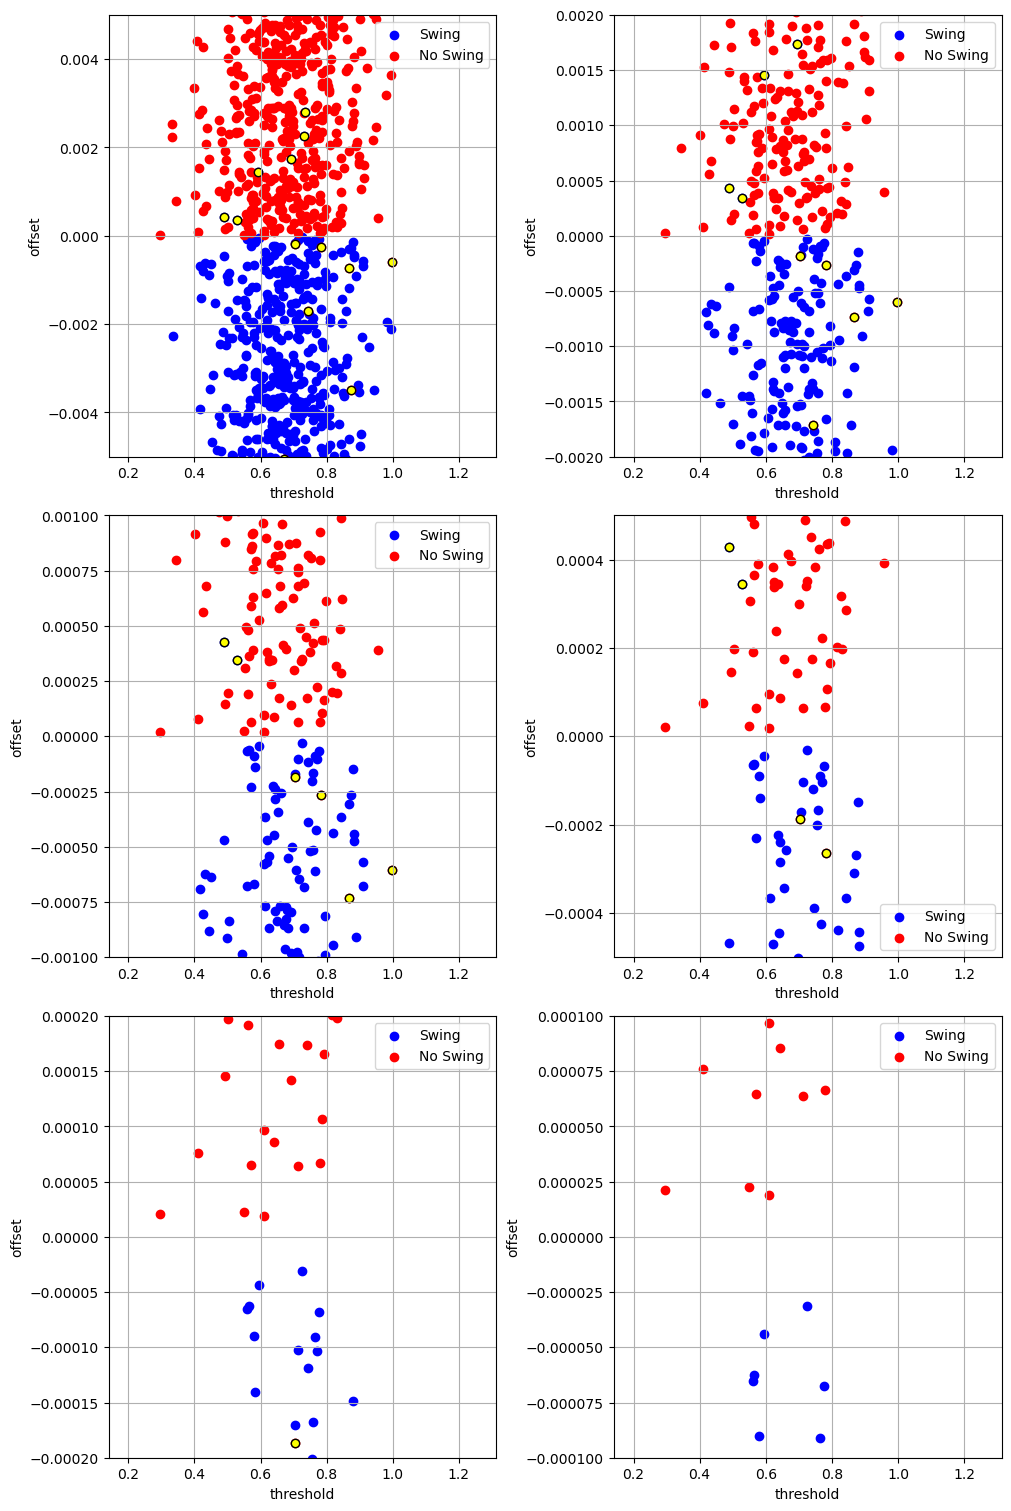

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15), layout="constrained")
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Swing",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Swing",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="yellow",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="yellow",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    # ax.set_yscale("log")
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/swing_strike_fit_offsets.png", facecolor='white')